In [1]:
#pip install tensorflow==2.6.2

In [2]:
import pandas as pd
import numpy as np
import os


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed


import tensorflow
tensorflow.random.set_seed(101)

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

You Can Dowenload Data From https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000 this will be 3GB

**LABELS**<br>

Excerpts from the paper:<br>
 The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417

 **nv**
 *[6705 images]*
 **mel**
 *[1113 images]* 
**bkl**
*[1099 images]*
**bcc**
*[514 images]*
**akiec**
*[327 images]*
**vasc**
*[142 images]*
**df**
*[115 images]*
<br>*[Total images = 10015]*

In [3]:
os.listdir('D:\datasets\original\SkinCancer')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators. 

In [5]:
# Create a new directory fro new img
base_dir = 'base_dir'
os.mkdir(base_dir)
# now we create 7 folders inside (BASE DIRECTORY)'base_dir':

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



### Create Train and Val Sets

In [6]:
df_data = pd.read_csv('D:\datasets\original\SkinCancer\HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Create a stratified val set

In [7]:
df = df_data.groupby('lesion_id').count()
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [8]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

df_data['duplicates'] = df_data['lesion_id']

df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [9]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [10]:
df = df_data[df_data['duplicates'] == 'no_duplicates']
df.shape

(5514, 8)

In [11]:
y = df['dx']
_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)
df_val.shape

(938, 8)

In [12]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Create a train set that excludes images that are in the val set

In [13]:

def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [14]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [15]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Transfer the Images into the Folders

In [16]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [17]:

folder_1 = os.listdir('D:\datasets\original\SkinCancer\ham10000_images_part_1')
folder_2 = os.listdir('D:\datasets\original\SkinCancer\ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
       
        src = os.path.join('D:\datasets\original\SkinCancer\ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        
        src = os.path.join('D:\datasets\original\SkinCancer\ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)
for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
       
        src = os.path.join('D:\datasets\original\SkinCancer\ham10000_images_part_1', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('D:\datasets\original\SkinCancer\ham10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)
        

In [18]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [19]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


### Copy the train images  into aug_dir

In [20]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']
for item in class_list:
    aug_dir = 'aug_dir1'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)
    img_class = item
    img_list = os.listdir('base_dir/train_dir/' + img_class)
    for fname in img_list:
            
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
    shutil.rmtree('aug_dir1')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [21]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [22]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


### Visualize 50 augmented images

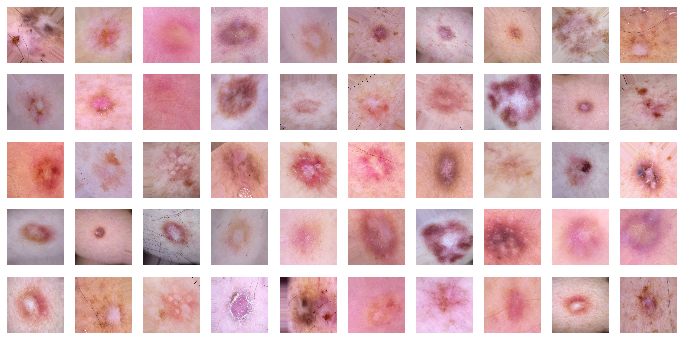

In [23]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [24]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Set Up the Generators

In [25]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [26]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


### Modify MobileNet Model

In [27]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [28]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [29]:
type(mobile.layers)

list

In [30]:
# How many layers does MobileNet have?
len(mobile.layers)

92

In [31]:
# Exclude the last 5 layers of the above model This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [33]:
for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [34]:
# Define Top2 and Top3 Accuracy
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [35]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

C:\Users\SkinCancerProj\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [36]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [37]:
# Add weights to try to make the model more sensitive to melanoma
# To solve Imbalancedd data problem

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel 
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [38]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


C:\Users\SkinCancerProj\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
908/908 [==============================] - 431s 472ms/step - loss: 1.6766 - categorical_accuracy: 0.5207 - top_2_accuracy: 0.7272 - top_3_accuracy: 0.8498 - val_loss: 1.5723 - val_categorical_accuracy: 0.4925 - val_top_2_accuracy: 0.6972 - val_top_3_accuracy: 0.9414

Epoch 00001: val_top_3_accuracy improved from -inf to 0.94136, saving model to model.h5
Epoch 2/30
908/908 [==============================] - 423s 465ms/step - loss: 1.2438 - categorical_accuracy: 0.6236 - top_2_accuracy: 0.8205 - top_3_accuracy: 0.9189 - val_loss: 1.2211 - val_categorical_accuracy: 0.6077 - val_top_2_accuracy: 0.9041 - val_top_3_accuracy: 0.9595

Epoch 00002: val_top_3_accuracy improved from 0.94136 to 0.95949, saving model to model.h5
Epoch 3/30
908/908 [==============================] - 420s 462ms/step - loss: 1.0649 - categorical_accuracy: 0.6664 - top_2_accuracy: 0.8561 - top_3_accuracy: 0.9431 - val_loss: 0.5261 - val_categorical_accuracy: 0.8241 - val_top_2_accuracy: 0.9115 - val_top_3_ac

908/908 [==============================] - 391s 431ms/step - loss: 0.2651 - categorical_accuracy: 0.9202 - top_2_accuracy: 0.9845 - top_3_accuracy: 0.9982 - val_loss: 0.3391 - val_categorical_accuracy: 0.8913 - val_top_2_accuracy: 0.9648 - val_top_3_accuracy: 0.9861

Epoch 00023: val_top_3_accuracy did not improve from 0.98827
Epoch 24/30
908/908 [==============================] - 391s 431ms/step - loss: 0.2482 - categorical_accuracy: 0.9210 - top_2_accuracy: 0.9876 - top_3_accuracy: 0.9980 - val_loss: 0.3338 - val_categorical_accuracy: 0.8934 - val_top_2_accuracy: 0.9627 - val_top_3_accuracy: 0.9861

Epoch 00024: val_top_3_accuracy did not improve from 0.98827

Epoch 00024: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Epoch 25/30
908/908 [==============================] - 395s 435ms/step - loss: 0.2525 - categorical_accuracy: 0.9211 - top_2_accuracy: 0.9859 - top_3_accuracy: 0.9978 - val_loss: 0.3364 - val_categorical_accuracy: 0.8966 - val_top_2_accuracy: 0.9648

In [39]:
tensorflow.__version__

'2.6.2'

In [40]:
#pip install --upgrade pip

In [41]:
#pip install tensorflow==2.6.2 --user

### Evaluate the model using the val set

In [42]:
#pip uninstall tensorflow

In [43]:
#import tensorflow

In [44]:
#tensorflow.__version__

In [45]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [46]:
# we use last epoch 

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\SkinCancerProj\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.33516329526901245
val_cat_acc: 0.89552241563797
val_top_2_acc: 0.9637526869773865
val_top_3_acc: 0.9872068166732788


In [47]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.37876394391059875
val_cat_acc: 0.863539457321167
val_top_2_acc: 0.9605543613433838
val_top_3_acc: 0.9882729053497314


### Plot the Training Curves display the loss and accuracy curves

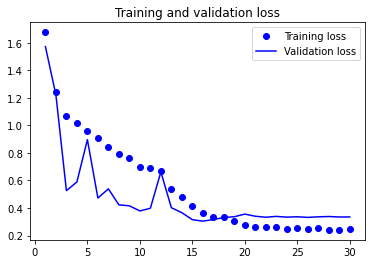

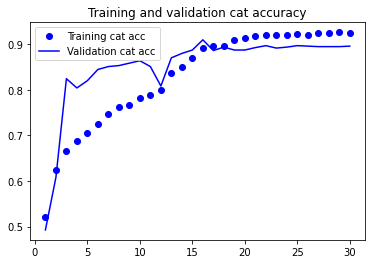

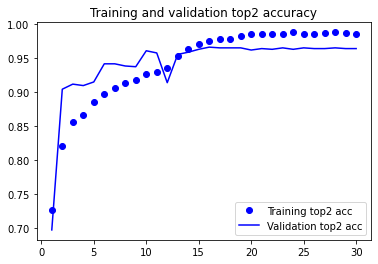

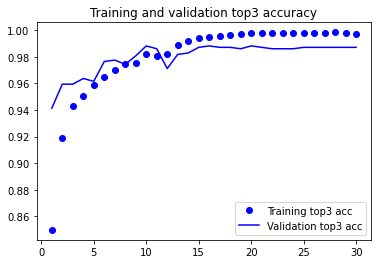

In [48]:

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [ ]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

In [ ]:
# Print the label associated with each class
test_batches.class_indices

In [ ]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Define the labels of the class indices. These need to match the 

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

## Delete the image data directory we created to Avoid Errors

In [ ]:
shutil.rmtree('base_dir')